# Проект: Мультимодальная система анализа и предсказания временных рядов с использованием CNN и LSTM


### 1. Сбор данных

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Colab Notebooks/Exrate.xlsx'

df = pd.read_excel(file_path)

df


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,USD,EUR,CNY,RUB
0,01.01.2000,138.20,143.65,16.69,5.03
1,02.01.2000,138.20,143.65,16.69,5.03
2,03.01.2000,138.20,143.65,16.69,5.03
3,04.01.2000,138.20,143.65,16.69,5.03
4,05.01.2000,138.20,146.55,16.69,5.03
...,...,...,...,...,...
9152,12.02.2025,506.43,522.43,69.31,5.28
9153,13.02.2025,501.31,520.11,68.59,5.33
9154,14.02.2025,497.88,518.59,68.27,5.44
9155,15.02.2025,495.28,518.41,68.18,5.44


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9157 entries, 0 to 9156
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    9157 non-null   object 
 1   USD     9157 non-null   float64
 2   EUR     9157 non-null   float64
 3   CNY     9157 non-null   float64
 4   RUB     9157 non-null   float64
dtypes: float64(4), object(1)
memory usage: 357.8+ KB


In [46]:
df.describe()

,USD,EUR,CNY,RUB
count,9157.000000,9157.000000,9157.000000,9157.000000
mean,241.460648,279.453341,34.780181,5.084479
std,129.399099,136.904954,19.584461,0.690997
min,117.250000,121.250000,14.680000,2.620000
25%,145.250000,167.300000,17.600000,4.750000
50%,152.250000,204.600000,23.550000,4.950000
75%,371.550000,419.500000,54.020000,5.390000
max,530.240000,563.560000,80.760000,9.100000


### 2. Предобработка данных
Обработка пропущенных значений.                        
Нормализация данных для улучшения производительности моделей.                   
Разделение данных на обучающую, валидационную и тестовую выборки.                              


In [47]:
df.isnull().sum()

,0
Date,0
USD,0
EUR,0
CNY,0
RUB,0


In [48]:
scaler = MinMaxScaler()
dfscal= df.copy()
dfscal[["USD", "EUR", "CNY", "RUB"]] = scaler.fit_transform(df[["USD", "EUR", "CNY", "RUB"]])

In [8]:
#train, test = train_test_split(df, test_size=0.2, random_state=42)
#train, val = train_test_split(train, test_size=0.2, random_state=42)

In [9]:
#train

### 3. Разведочный анализ данных (EDA)
Визуализация временных рядов для выявления трендов и сезонности.
Анализ корреляций между различными признаками.


In [49]:
df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y")
df.set_index("Date", inplace=True)

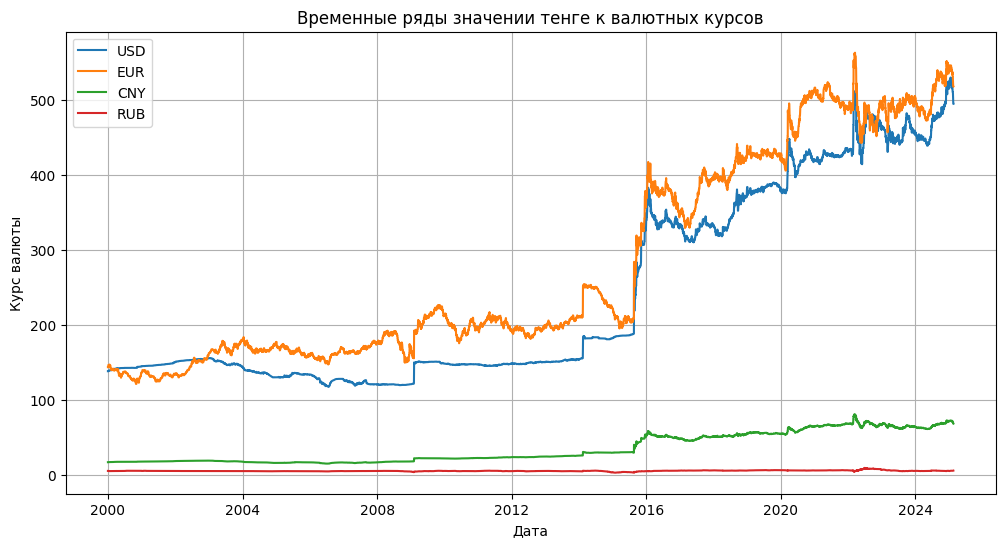

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
for col in ["USD", "EUR", "CNY", "RUB"]:
    plt.plot(df.index, df[col], label=col)
plt.legend()
plt.title("Временные ряды значении тенге к валютных курсов")
plt.xlabel("Дата")
plt.ylabel("Курc валюты")
plt.grid()
plt.show()

In [53]:
dfscal["Date"] = pd.to_datetime(dfscal["Date"], format="%d.%m.%Y")
dfscal.set_index("Date", inplace=True)

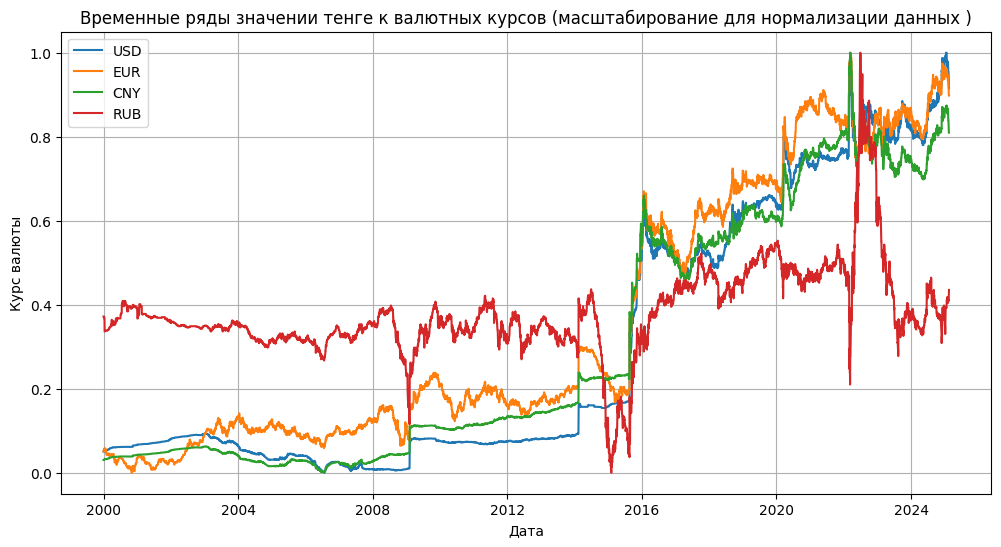

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
for i in ["USD", "EUR", "CNY", "RUB"]:
    plt.plot(dfscal.index, dfscal[i], label=i)
plt.legend()
plt.title("Временные ряды значении тенге к валютных курсов (масштабирование для нормализации данных )")
plt.xlabel("Дата")
plt.ylabel("Курc валюты")
plt.grid()
plt.show()

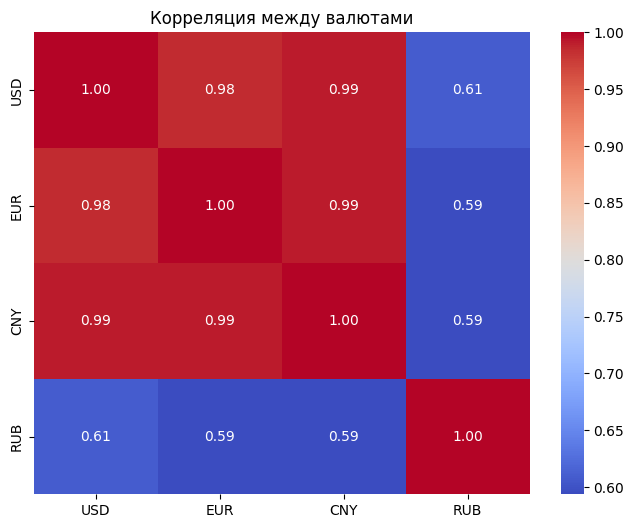

In [55]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляция между валютами")
plt.show()

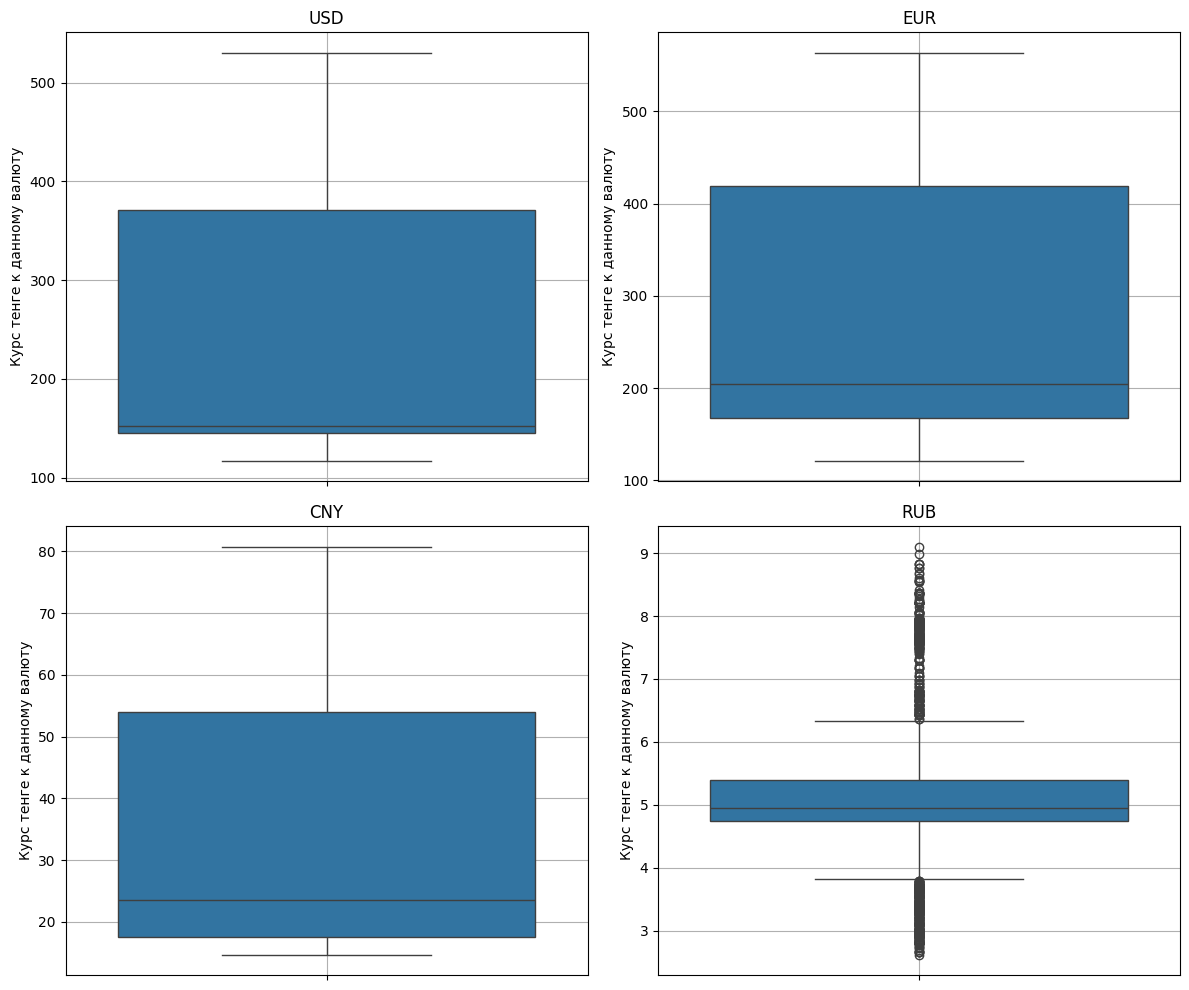

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
currencies = ["USD", "EUR", "CNY", "RUB"]
titles = ["USD", "EUR", "CNY", "RUB"]

for ax, col, title in zip(axes.flatten(), currencies, titles):
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(title)
    ax.set_ylabel("Курс тенге к данному валюту")
    ax.grid(True)

plt.tight_layout()
plt.show()

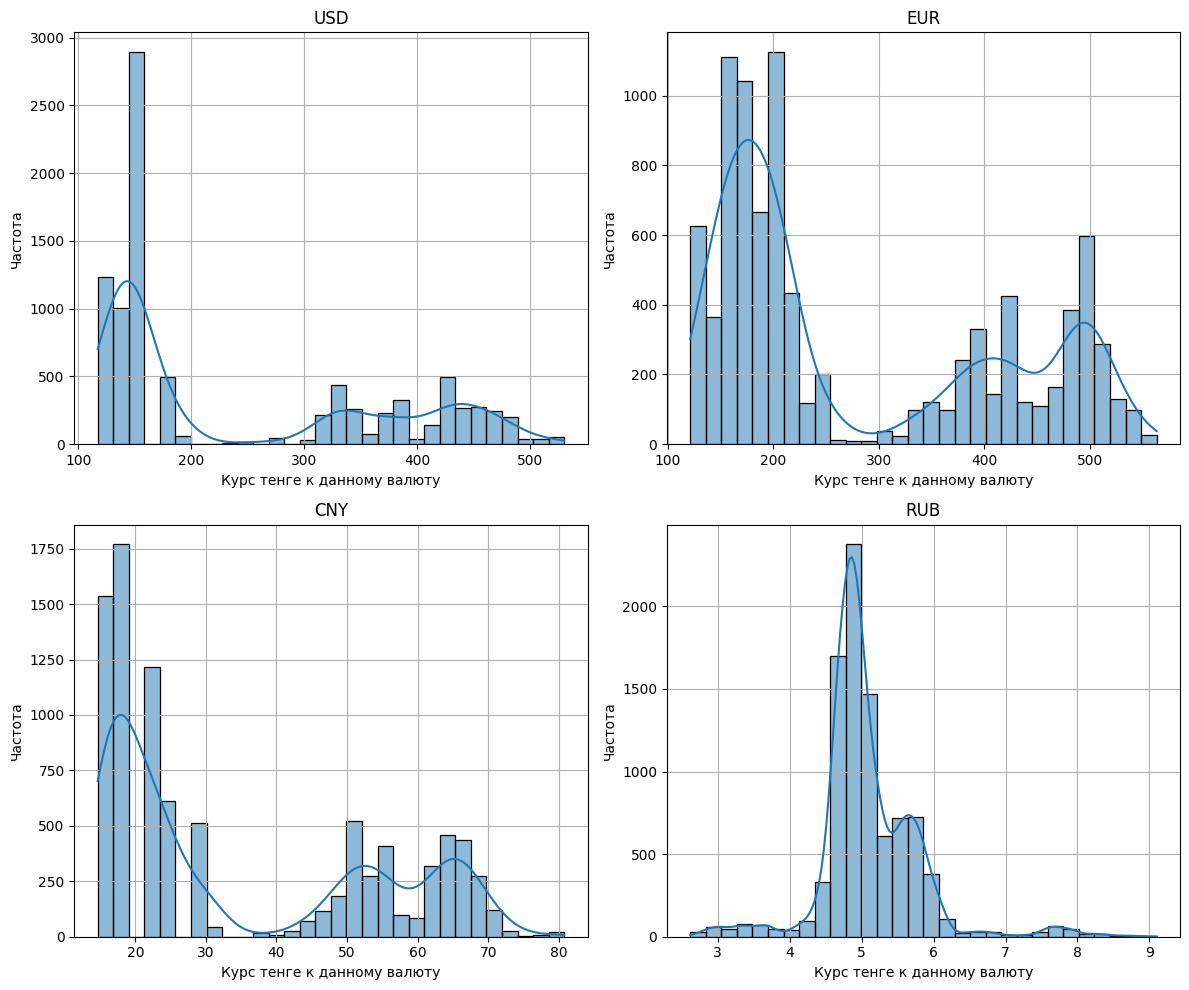

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
currencies = ["USD", "EUR", "CNY", "RUB"]
titles = ["USD", "EUR", "CNY", "RUB"]

for ax, col, title in zip(axes.flatten(), currencies, titles):
    sns.histplot(df[col], kde=True, bins=30, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Курс тенге к данному валюту")
    ax.set_ylabel("Частота")
    ax.grid(True)

plt.tight_layout()
plt.show()


### 4. Извлечение признаков с помощью CNN
Создайте свёрточную нейронную сеть для извлечения признаков из временных рядов. Используйте 1D свёрточные слои для обработки последовательных данных.                        
Оптимизируйте архитектуру сети, используя различные конфигурации слоёв и параметры.                      


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 30, 64)              │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 15, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 15, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,460 (185.39 KB)

 Trainable params: 47,460 (185.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - loss: 0.0179 - mae: 0.0853 - val_loss: 0.0065 - val_mae: 0.0644
Epoch 2/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0037 - mae: 0.0411 - val_loss: 0.0090 - val_mae: 0.0804
Epoch 3/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 0.0026 - mae: 0.0338 - val_loss: 0.0104 - val_mae: 0.0852
Epoch 4/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0021 - mae: 0.0301 - val_loss: 0.0104 - val_mae: 0.0866
Epoch 5/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0017 - mae: 0.0277 - val_loss: 0.0030 - val_mae: 0.0397
Epoch 6/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0016 - mae: 0.0267 - val_loss: 0.0035 - val_mae: 0.0451
Epoch 7/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.0013 - mae: 0.0242 - val_loss: 0.0060 - val_mae: 0.0644
Epoch 8/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0012 - mae: 0.0228 - val_loss: 0.0057 - val_mae: 0.0612
Epoch 9/20
229/229 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms

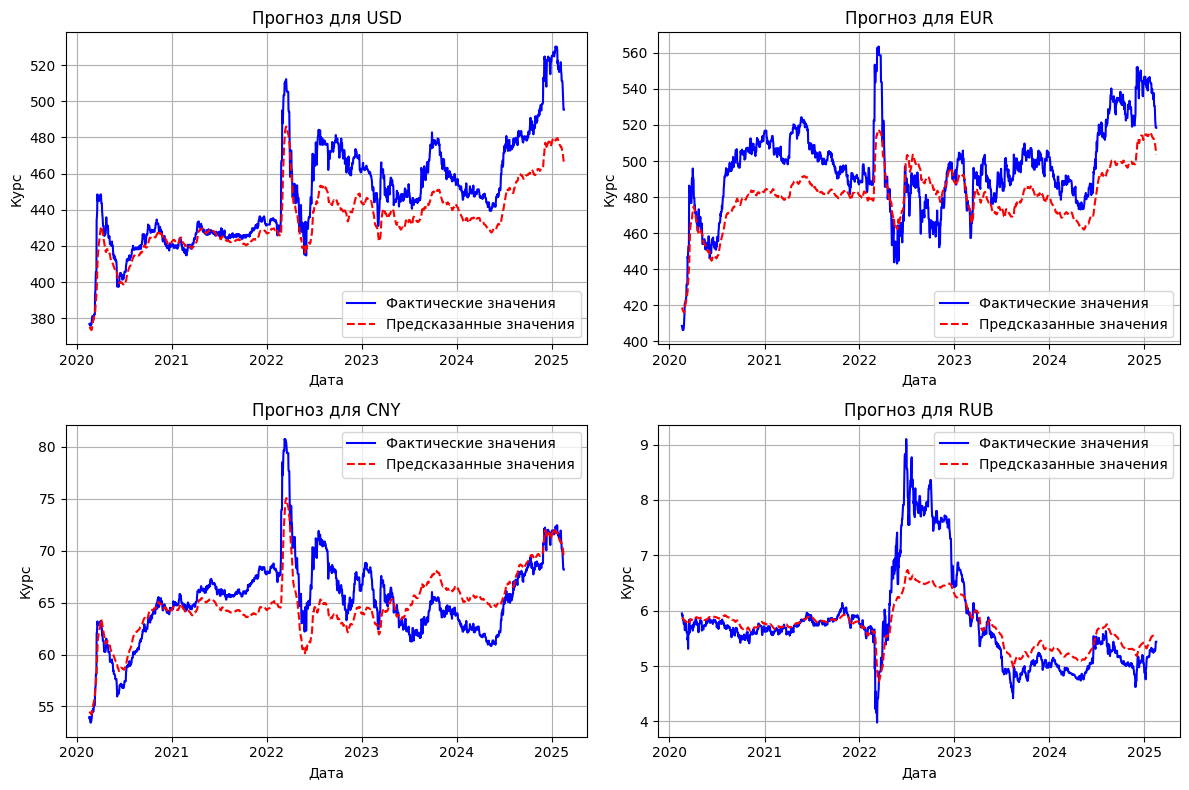

In [64]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

file_path = '/content/drive/MyDrive/Colab Notebooks/Exrate.xlsx'
df = pd.read_excel(file_path)

df["Date"] = pd.to_datetime(df["Date"], format="%d.%m.%Y")
df.set_index("Date", inplace=True)

scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[["USD", "EUR", "CNY", "RUB"]] = scaler.fit_transform(df[["USD", "EUR", "CNY", "RUB"]])

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 30  # Количество дней в последовательности
FEATURES = ["USD", "EUR", "CNY", "RUB"]
X, y = create_sequences(df_scaled[FEATURES].values, SEQ_LENGTH)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = Sequential([
    # CNN часть
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(SEQ_LENGTH, len(FEATURES))),
    MaxPooling1D(pool_size=2),

    # LSTM часть
    LSTM(64, return_sequences=True, activation='tanh'),
    LSTM(32,activation='tanh'),

    # Полносвязные слои
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(FEATURES))  # Выходное количество нейронов = количеству валют
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

# **Обучение модели**
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# **Оценка точности**
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.4f}")

# **Предсказание**
y_pred = model.predict(X_test)

# **Денормализация предсказаний**
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# **Визуализация предсказаний**
plt.figure(figsize=(12, 8))
for i, currency in enumerate(FEATURES):
    plt.subplot(2, 2, i+1)
    plt.plot(df.index[-len(y_test):], y_test_inv[:, i], label="Фактические значения", color='blue')
    plt.plot(df.index[-len(y_test):], y_pred_inv[:, i], label="Предсказанные значения", color='red', linestyle='dashed')
    plt.title(f"Прогноз для {currency}")
    plt.xlabel("Дата")
    plt.ylabel("Курс")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()
